In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [3]:
data = pd.read_csv('data.csv')
data = data.drop('country', axis=1)

display(data.head())

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]

X = (data - data.min()) / (data.max() - data.min())
display(X.head())

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.650224,0.113963,0.570702,0.484514,0.022348,0.434279,0.140468,0.862782,0.010534
1,0.100149,0.321358,0.465921,0.524500,0.208100,0.236516,0.812709,0.078947,0.126239
2,0.180120,0.441186,0.223805,0.338622,0.274408,0.700360,0.819398,0.312030,0.138343
3,0.865471,0.716560,0.089522,0.462901,0.118126,0.952058,0.270903,0.926692,0.107920
4,0.053064,0.522992,0.413021,0.635810,0.412828,0.114662,0.829431,0.169173,0.391540


In [5]:
def pca(X, n_components=2):
    # Center the data
    X_centered = X - np.mean(X, axis=0)
    
    # Compute covariance matrix
    cov_matrix = np.cov(X_centered.T)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    # Select top n_components
    selected_eigenvectors = sorted_eigenvectors[:, :n_components]
    
    # Project data onto new feature space
    X_pca = X_centered @ selected_eigenvectors
    
    # Calculate explained variance ratio
    total_variance = np.sum(sorted_eigenvalues)
    explained_variance_ratio = sorted_eigenvalues[:n_components] / total_variance
    print(explained_variance_ratio)
    return X_pca, explained_variance_ratio

# Apply PCA
X_pca, explained_variance = pca(X)
display(X_pca.head())

[0.51127001 0.14395056]


,0,1
0,-0.841292,0.206726
1,0.271532,0.070238
2,0.038081,-0.456152
3,-0.894436,-0.494926
4,0.489734,0.086509


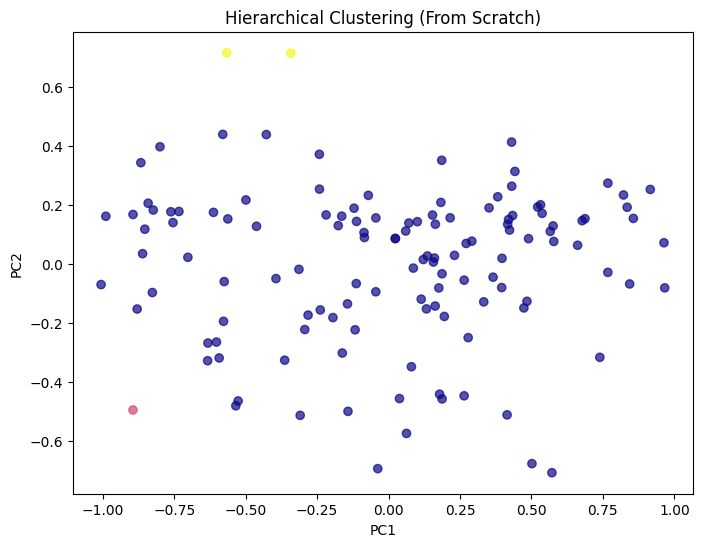


Cluster assignments (Hierarchical Clustering from Scratch):
   Cluster_Hierarchical_Scratch
0                             0
1                             0
2                             0
3                             1
4                             0


In [6]:
# Step 2: Hierarchical Clustering function
def hierarchical_clustering(data, k=3, method="single"):
    # Step 1: Start with each point as its own cluster
    clusters = [{i} for i in range(len(data))]
    distances = compute_pairwise_distances(data)
    history = []

    # Step 2: Iteratively merge clusters until the desired number of clusters is reached
    while len(clusters) > k:
        # Find the closest pair of clusters
        i, j = find_closest_clusters(clusters, distances, method)
        
        # Merge the two clusters
        merged_cluster = clusters[i].union(clusters[j])
        history.append((clusters[i], clusters[j]))
        clusters.pop(j)  # Remove the second cluster
        clusters[i] = merged_cluster  # Replace the first cluster with the merged cluster

    # Assign cluster labels
    cluster_labels = assign_cluster_labels(clusters, len(data))
    return cluster_labels, history


def compute_pairwise_distances(data):
    n = len(data)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            distances[i, j] = distances[j, i] = np.linalg.norm(data.iloc[i] - data.iloc[j])
    return distances


def find_closest_clusters(clusters, distances, method):
    min_dist = float("inf")
    closest_pair = (-1, -1)

    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            dist = compute_cluster_distance(clusters[i], clusters[j], distances, method)
            if dist < min_dist:
                min_dist = dist
                closest_pair = (i, j)

    return closest_pair


def compute_cluster_distance(cluster1, cluster2, distances, method):
    if method == "single":
        return min(distances[i, j] for i in cluster1 for j in cluster2)
    elif method == "complete":
        return max(distances[i, j] for i in cluster1 for j in cluster2)
    elif method == "average":
        return np.mean([distances[i, j] for i in cluster1 for j in cluster2])
    else:
        raise ValueError("Invalid linkage method. Choose from 'single', 'complete', or 'average'.")


def assign_cluster_labels(clusters, n_points):
    labels = np.zeros(n_points, dtype=int)
    for cluster_id, cluster in enumerate(clusters):
        for point in cluster:
            labels[point] = cluster_id
    return labels

# Perform Hierarchical Clustering
k = 3  # Desired number of clusters
hierarchical_labels, merge_history = hierarchical_clustering(X_pca, k=k, method="single")
# Add cluster labels to the PCA data
X_pca['Cluster_Hierarchical_Scratch'] = hierarchical_labels
# Step 3: Visualize the Results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[0], X_pca[1], c= X_pca['Cluster_Hierarchical_Scratch'], cmap='plasma', alpha=0.7)
plt.title('Hierarchical Clustering (From Scratch)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Display the cluster assignments
print("\nCluster assignments (Hierarchical Clustering from Scratch):")
print(X_pca[['Cluster_Hierarchical_Scratch']].head())

In [17]:
import numpy as np
from sklearn.metrics import pairwise_distances

def silhouette_score(X, labels):
    n_samples = len(X)
    distances = pairwise_distances(X)  # Pairwise distances between all points

    # Calculate the silhouette score for each sample
    a = np.zeros(n_samples)  # a(i): average distance within the same cluster
    b = np.zeros(n_samples)  # b(i): average distance to the nearest cluster
    
    for i in range(n_samples):
        same_cluster = X[labels == labels[i]]  # Points in the same cluster as i
        other_clusters = X[labels != labels[i]]  # Points in other clusters
        
        # a(i): Average distance between i and other points in the same cluster
        a[i] = np.mean(distances[i, labels == labels[i]])  
        
        # b(i): Average distance to the nearest other cluster
        b[i] = np.min([np.mean(distances[i, labels == c]) for c in np.unique(labels) if c != labels[i]])
    
    # Silhouette score for each point
    s = (b - a) / np.maximum(a, b)
    
    # Return the average silhouette score
    return np.mean(s)
# Calculate silhouette score
silhouette = silhouette_score(X_pca, hierarchical_labels)

ModuleNotFoundError: No module named 'sklearn'

In [8]:
def calculate_inertia(X, labels):
    # Get the unique cluster labels
    unique_labels = np.unique(labels)
    
    inertia = 0
    for label in unique_labels:
        # Get all points assigned to the current cluster
        cluster_points = X[labels == label]
        
        # Calculate the centroid (mean of points in the cluster)
        centroid = np.mean(cluster_points, axis=0)
        
        # Calculate the squared distances to the centroid for all points in the cluster
        squared_distances = np.sum((cluster_points - centroid) ** 2, axis=1)
        
        # Add the squared distances to the total inertia
        inertia += np.sum(squared_distances)
    
    return inertia

# Example: Calculate inertia for hierarchical clustering
inertia = calculate_inertia(X_pca, hierarchical_labels)

In [18]:
from scipy.spatial.distance import cdist

def calculate_dunn_index(X, labels):
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    # Step 1: Compute intra-cluster distances (diameters)
    intra_cluster_distances = []
    for label in unique_labels:
        # Get points in the current cluster
        cluster_points = X[labels == label]
        
        # Calculate pairwise distances within the cluster
        distances = cdist(cluster_points, cluster_points)
        
        # Find the maximum distance (diameter of the cluster)
        max_distance = np.max(distances)
        intra_cluster_distances.append(max_distance)
    
    # Step 2: Compute inter-cluster distances (minimum distance between any two clusters)
    inter_cluster_distances = []
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            # Get points in the two clusters
            cluster_i_points = X[labels == unique_labels[i]]
            cluster_j_points = X[labels == unique_labels[j]]
             # Calculate pairwise distances between the two clusters
            distances = cdist(cluster_i_points, cluster_j_points)
            
            # Find the minimum distance between the two clusters
            min_distance = np.min(distances)
            inter_cluster_distances.append(min_distance)
    
    # Step 3: Calculate Dunn Index
    dunn_index = np.min(inter_cluster_distances) / np.max(intra_cluster_distances)
    
    return dunn_index

# Example: Calculate Dunn Index for hierarchical clustering
dunn_index = calculate_dunn_index(X_pca, hierarchical_labels)

In [19]:
print("Clustering Evaluation:")
print(f'Silhouette Score: {silhouette}')
print(f"Dunn Index: {dunn_index}")
print(f"Inertia: {inertia}")

Clustering Evaluation:


NameError: name 'silhouette' is not defined

In [20]:
X_pca = X_pca.to_numpy() if isinstance(X_pca, pd.DataFrame) else X_pca
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import pairwise_distances

def plot_clusters(X_pca, labels, title='Cluster Visualization'):
    # Create a scatter plot for the first two components of PCA
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='plasma', alpha=0.7)

    # Add a color bar to indicate the clusters
    plt.colorbar(scatter, label='Cluster Label')

    # Add labels and title
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)

    # Show the plot
    plt.show()

# Visualize the clusters (using the hierarchical clustering labels)
plot_clusters(X_pca, hierarchical_labels, title='Hierarchical Clustering Results')
def plot_elbow_method_hierarchical(X_pca, max_k=10):
    # Perform hierarchical clustering using 'ward' linkage method
    Z = linkage(X_pca, method='ward')
    wcss = []  # To store the WCSS for different k values

    for k in range(1, max_k + 1):
        # Assign clusters
        labels = fcluster(Z, k, criterion='maxclust')
        
        # Compute WCSS (Within-Cluster Sum of Squares)
        wcss_value = 0
        for cluster_id in range(1, k+1):
            cluster_points = X_pca[labels == cluster_id]
            centroid = cluster_points.mean(axis=0)
            wcss_value += np.sum((cluster_points - centroid) ** 2)
        
        wcss.append(wcss_value)
    
    # Plot WCSS vs number of clusters
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_k + 1), wcss, marker='o')
    plt.title('Elbow Method for Hierarchical Clustering')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
    plt.grid(True)
    plt.show()

# Example usage
plot_elbow_method_hierarchical(X_pca, max_k=10)

ModuleNotFoundError: No module named 'sklearn'

In [13]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster

# Silhouette Score for Hierarchical Clustering
def plot_silhouette_score_hierarchical(X_pca, max_k=10):
    silhouette_scores = []  # List to store silhouette scores for each k
    
    # Perform hierarchical clustering using 'ward' linkage method
    Z = linkage(X_pca, method='ward')

    for k in range(2, max_k + 1):  # Start from 2 clusters, since silhouette score is undefined for k=1
        # Assign clusters
        labels = fcluster(Z, k, criterion='maxclust')

        # Compute silhouette score
        score = silhouette_score(X_pca, labels)
        silhouette_scores.append(score)

    # Plot silhouette score vs number of clusters
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Score for Hierarchical Clustering')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

# Example usage
plot_silhouette_score_hierarchical(X_pca, max_k=10)

ModuleNotFoundError: No module named 'sklearn'